<a href="https://colab.research.google.com/github/n-vit/YaP_Projects/blob/main/time_series_service%20load%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Общий-обзор" data-toc-modified-id="Общий-обзор-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Общий обзор</a></span></li><li><span><a href="#Актуальный-период" data-toc-modified-id="Актуальный-период-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Актуальный период</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM-модель" data-toc-modified-id="LightGBM-модель-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM модель</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Тест-линейная-регрессия" data-toc-modified-id="Тест-линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Тест линейная регрессия</a></span></li><li><span><a href="#Тест-случайный-лес" data-toc-modified-id="Тест-случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Тест случайный лес</a></span></li><li><span><a href="#Тест-градиентный-бустинг" data-toc-modified-id="Тест-градиентный-бустинг-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Тест градиентный бустинг</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [ ]:
# libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import adfuller

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# metrics
from sklearn.metrics import mean_squared_error

## Подготовка

In [ ]:
try: # if the project is opened in Collab use a 'try' block, if it opened in simulator Yandex, or local Jupiter, use an 'except' block
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

## Анализ

In [ ]:
df.sort_index(inplace=True)
print(df.index.is_monotonic)
df.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


У нас монотонный временной ряд из 26 тыс строк в период с  1 марта по 31 августа 2018 года. 

Посмотрим на данные о количестве заказов:

### Общий обзор

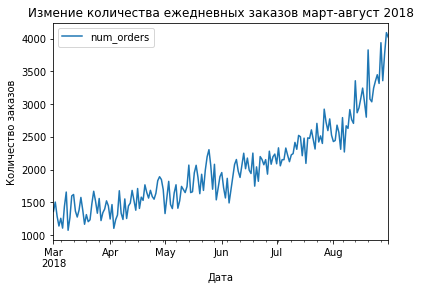

In [ ]:
daily = df.resample('1D').sum()
figsize = (17,10)
daily.plot()
plt.title('Измение количества ежедневных заказов март-август 2018')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Дела обстоят неплохо, количество заказов к концу лета выросло почти в три раза

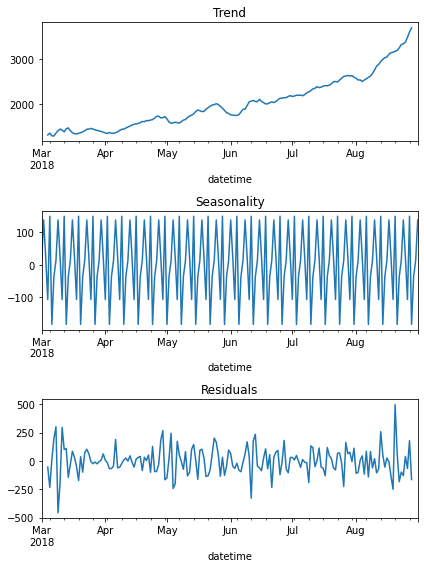

In [ ]:
decomposed = seasonal_decompose(daily)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Видим растущий тренд, стационарный стохастический процесс недельных колебаний, и выбросы с экстремумами +/- 500 заказов в день, которые впрочем в основном укладываются в 100-200 заказов

Посмотрим почасовой график изменения заказов в последние две недели фрейма (с 18сб по 31пт августа):

### Актуальный период

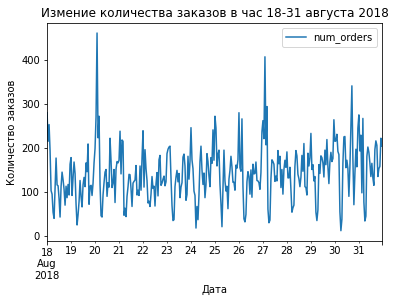

In [ ]:
df = df.resample('1H').sum()
figsize = (17,10)
df['2018-08-18':'2018-08-31'].plot()
plt.title('Измение количества заказов в час 18-31 августа 2018')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

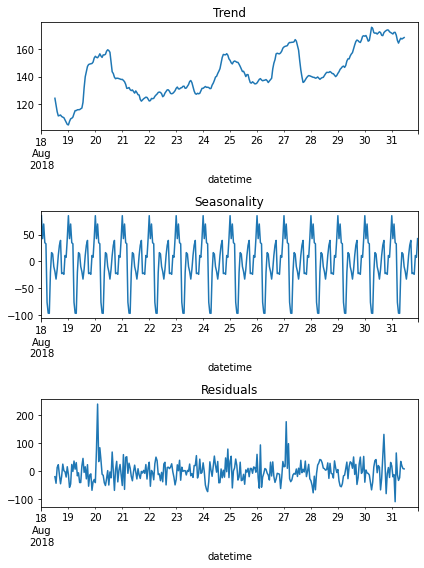

In [ ]:
decomposed = seasonal_decompose(df['2018-08-18':'2018-08-31'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

- Растущий тренд с пиками по понедельникам, с недельным темпом роста 20 заказов в день. В признаках должен быть день недели

- Внутри дня стационарные суточные колебания в диапазоне 170 заказов. Нужно будет обязательно включить час в признаки

- Событийные выбросы 20, 27, 30 августа, которые дают пики в 150-200 заказов в день и 31 августа -100 заказов. Попробуем не удалять выбросы и научиться на полной модели

- Цель - предсказывать количество заказов с ошибкой в пределах 48 заказов в час выглядит реалистично

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*Ок, проверим:
    
Нулевая гипотеза - Ряд не стационарен
    
Альтернативная гипотеза - Ряд стационарен*
</div>

In [ ]:
p_value = adfuller(df['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. И все-таки он стационарный')
else:
    print('Нулевая гипотеза не отвергается. Глаза мои обманывают меня - ряд нестационарен')

P = 0.028940051402612906
Нулевая гипотеза отвергается. И все-таки он стационарный


<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

**Выводы по итогам анализа исходных данных:**
    
1) заказы такси за период с марта по август показывают уверенный экспоненциальный рост тренда
    
2) Временной ряд стационарен. У него есть регулярные сезонные (суточные и недельные) колебания, и незначительный объем выбросов в остатках
    
3) Данные позволяют проводить обучение моделей и предсказание ожидаемого объема заказов   

</div>

## Обучение

Создадим признаки модели:

месяц, день, день недели и час

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*Добавил копирование фрейма в шаге разбивки на учебную и тестовую выборки. 
 Что касается месяца - посмотри на график тренда за весь период (выше). во всех месяцах кроме июля прослеживается пик роста в третьей чевтерти месяца, и замедление к четвертой, т.е. сезонность присутствует не только по часам и дням недели, но и по номерам недель и месяцам. В любом случае год у нас единственный, а месяцев - шесть, поэтому думаю месяц стоит оставить*
</div>

Определим максимальный размер отставания (лаг):

поскольку сезонная декомпозиция стационарна, можно определить лаг как дистанцию в часах между максимальными и минимальными пиками

In [ ]:
'''
df_lag = seasonal_decompose(df['2018-08-18':'2018-08-31'])
max_lag = abs(((df_lag.seasonal.idxmax() - df_lag.seasonal.idxmin())
    //np.timedelta64(1, 'h'))[0])
print('Максимальный лаг:', max_lag)
'''

"\ndf_lag = seasonal_decompose(df['2018-08-18':'2018-08-31'])\nmax_lag = abs(((df_lag.seasonal.idxmax() - df_lag.seasonal.idxmin())\n    //np.timedelta64(1, 'h'))[0])\nprint('Максимальный лаг:', max_lag)\n"

Определим ширину окна по минимальной разнице (среднеквадратичной ошибке) между скользящей средней и реальными данными в двухнедельном диапазоне:

In [ ]:
dict = {}
for rolling_mean_size in range(2,48):
    data = df['2018-08-18':'2018-08-31'].copy() 
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    index = data.index
    num_orders = data['num_orders']
    rolling_mean = data['rolling_mean']
    rmse = mean_squared_error(num_orders,rolling_mean)**0.5
    dict[rolling_mean_size] = rmse
rolling_mean_size = min(dict.keys(), key=(lambda x: dict[x]))
print('Оптимальный размер окна:', rolling_mean_size)

Оптимальный размер окна: 2


Разобъем выборку на учебную и тестовую 

In [ ]:
df_new = df.copy()
make_features(df_new, 24, 24)

train, test = train_test_split(df_new, shuffle=False, 
                               test_size=0.1, 
                               random_state=12345)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

### Линейная регрессия



In [ ]:
lr_params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [ ]:
%%time
lr_grid = GridSearchCV(LinearRegression(), param_grid = lr_params, refit=False, scoring='neg_mean_squared_error', cv=tscv)
lr_grid.fit(features_train, target_train)
lr_best_params = lr_grid.best_params_
    
print('Гиперпараметры линейной регрессии на кросс-валидации: ', lr_best_params)

Гиперпараметры линейной регрессии на кросс-валидации:  {'copy_X': True, 'fit_intercept': True, 'normalize': False}
CPU times: user 2.02 s, sys: 2.94 s, total: 4.96 s
Wall time: 4.94 s


In [ ]:
lr_best_params = {'copy_X': True, 'fit_intercept': True, 'normalize': False}

### Случайный лес

In [ ]:
rf_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'verbose' : [0],
        'random_state' : [12345] 
        }

In [ ]:
'''
%%time
rf_grid = GridSearchCV(RandomForestRegressor(), 
                       param_grid = rf_params, 
                       refit=False, 
                       scoring='neg_mean_squared_error', 
                       cv=tscv)
rf_grid.fit(features_train, target_train)
rf_best_params = rf_grid.best_params_
rf_m = RandomForestRegressor(**rf_best_params)
rf_m.fit(features_train, target_train) 

print('Лучшие гиперпараметры в случайном лесу: ', rf_best_params)
'''

"\n%%time\nrf_grid = GridSearchCV(RandomForestRegressor(), \n                       param_grid = rf_params, \n                       refit=False, \n                       scoring='neg_mean_squared_error', \n                       cv=tscv)\nrf_grid.fit(features_train, target_train)\nrf_best_params = rf_grid.best_params_\nrf_m = RandomForestRegressor(**rf_best_params)\nrf_m.fit(features_train, target_train) \n\nprint('Лучшие гиперпараметры в случайном лесу: ', rf_best_params)\n"

In [ ]:
rf_best_params = {'max_depth': 13, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}

В обучающей выборке сработало, обучим LightGBM

### LightGBM модель

In [ ]:
lgb_params = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'random_state' : [12345] 
        }

In [ ]:
'''
%%time
lgb_grid = GridSearchCV(LGBMRegressor(), 
                        param_grid = lgb_params, 
                        refit=False, 
                        scoring='neg_mean_squared_error', 
                        cv=tscv)
lgb_grid.fit(features_train, target_train)

lgb_best_params = lgb_grid.best_params_
lgb_m = LGBMRegressor(**lgb_best_params)
lgb_m.fit(features_train, target_train)
    
print('Лучшие гиперпараметры: ', lgb_best_params)
'''

"\n%%time\nlgb_grid = GridSearchCV(LGBMRegressor(), \n                        param_grid = lgb_params, \n                        refit=False, \n                        scoring='neg_mean_squared_error', \n                        cv=tscv)\nlgb_grid.fit(features_train, target_train)\n\nlgb_best_params = lgb_grid.best_params_\nlgb_m = LGBMRegressor(**lgb_best_params)\nlgb_m.fit(features_train, target_train)\n    \nprint('Лучшие гиперпараметры: ', lgb_best_params)\n"

In [ ]:
lgb_best_params = {
        'n_estimators' : 80,
        'max_depth' : 11,
        'random_state' : 12345 
        }

подобрали параметры бустинга, в этот раз кросс-валидация для временных рядов

## Тестирование

### Тест линейная регрессия

In [ ]:
%%time
lr_m = LinearRegression(**lr_best_params)
lr_m.fit(features_train, target_train)
lr_test_pred = lr_m.predict(features_test)
print("RMSE линейной регрессии на тестовой выборке: ", mean_squared_error(target_test, lr_test_pred)**0.5)

RMSE линейной регрессии на тестовой выборке:  45.810948889069486
CPU times: user 51.8 ms, sys: 95.6 ms, total: 147 ms
Wall time: 145 ms


### Тест случайный лес

In [ ]:
%%time
rf_m = RandomForestRegressor(**rf_best_params)
rf_m.fit(features_train, target_train) 
rf_test_pred = rf_m.predict(features_test)

print("RMSE случайного леса на тестовой выборке: ", mean_squared_error(target_test, rf_test_pred)**0.5)

RMSE случайного леса на тестовой выборке:  44.56546882317098
CPU times: user 4.28 s, sys: 171 ms, total: 4.45 s
Wall time: 4.48 s


чуть перевалили за нужный диапазон, но тест провален

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

И лес подтянулся
</div>

### Тест градиентный бустинг

In [ ]:
%%time
lgb_m = LGBMRegressor(**lgb_best_params)
lgb_m.fit(features_train, target_train)
lgb_test_pred = lgb_m.predict(features_test)

print("RMSE градиентного бустинга на тестовой выборке: ", mean_squared_error(target_test, lgb_test_pred)**0.5)


RMSE градиентного бустинга на тестовой выборке:  41.036147720799924
CPU times: user 1.19 s, sys: 0 ns, total: 1.19 s
Wall time: 1.12 s


Градиентный бустинг справился:

rmse на тестовой выборке обученной LGBMR: 
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Бустинг 41,03

**ВЫВОД:**
Все три обученных модели позволяют предсказывать заказы в заданных клиенту параметрах. Максимальная точность у градиентного бустинга (41 заказ), но линейная регрессия со среднеквадратичной ошибкой в 45 заказов отрабатывает значительно быстрее: 147 милисекунд против 1,19 секунд. Случайный лес самый долгий (4,45с) и точность почти такая же, как у линейной регрессии. 
 
    
Выбор из бустинга и линейки будет зависеть от требований ко времени действия.
    
</div>


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48